## Volcanology use-case (ash distribution simulations with FALL3DPy)

### Workflows for preparing project directory, json input file, downloading meteorological data, run the simulation and finally plot the results

author: M. Grund and R. Filgueira

last modified: 2020/04/16

### Introduction

This notebooks presents the dispel4py version for downloading (currently just NCRA) data, called f3_dispel4py.py .

The workflow prepares the project directory, a json dictionary (which also writes it as a file for user's records) with the desired configuration depending of the case example selected, and downloads the meteoreological data in sequential or parallel depending on the mapping selected to run it. 

### Input parameters to execute the workflow

This workflow only requires two input parameters:

* **pjtname**: Name of the your project. Our recommendation is to give a comprehensible    name e.g. `pjtname = Eruption_volcanoXY`, since your results will be stored in a newly created directory **/Simulations/pjtname** named exactly as your selected project name including the time stamp you started working on that project (e.g. EruptionExample_2019_12_13_130423)
    
* **case**: Eruption scenario to simulate. Chose one of the examples cases implemented so far (still under construction): Stromboli, Eifel, Tavurvur, Guntur

### General information

Download required meteorological data to your local machine

Meteorological data to download depends on:
* the agency (**NCAR** or **ERAIterim/ERA5**)
* monthly or daily means

Currently the download workflow is only implemented for **NCAR** data. 

Meteo data is currently locally saved in a database located in **/Simulations/MeteoDataBase** that contains directories for monthly and daily means of NCAR and ERA data. To avoid redundancies and time consuming downloads, first it is checked if required data is already available in the database.

* 1) For monthly means it is checked if newer data (newer months) are available, then the existing files are overwritten by the later ones. 
* 2) For daily means it is checked if the required "year" data (e.g. 2018) is already available, if yes, no download is started. Otherwise a new directory with the new "year" data is created in the database.

### How NCAR workflow works

The workflow for NCAR data consists of the following steps:

* generate all the necessary directories for a simulation
* generate an input dictionary with all the necessary configurations (according to the selected case) 
* generate list with all required files
* download the data based on filenames from ftp server using wget 

The first 3 steps are done by the **ProducerPE** while the last one is done by the **DownloadPE**. 

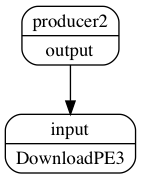

In [5]:
from IPython.display import Image
Image(filename='f3.png')

### Basic Information about dispel4py

dispel4py is a Python framework for describing abstract stream-based workflows for distributed
data-intensive applications.

Each stage of a dispel4py encoded method is represented as a Python object that takes data from zero or more input streams and emits data on zero or more output streams. Typically it applies a function to units of data taken from the input streams and emits units of data on its output streams. 

dispel4py works by mapping abstract workflows (what the user defines in his/her workflow script, e.g. f3_dispel4py.py ) into concrete workflows based on different the different mappings available (simple, multi, MPI) - which is what it is run in a computer resource (e.g. dispel4py simple f3_dispel4py.py ...). 

Both abstract workflow and concrete workflow are directed acyclic graph (DAG) consisting of edges and nodes. 

``` Abstract Workflow for this use case
graph = WorkflowGraph()
producer = ProducerPE()
producer.name = 'producer'
download = DownloadPE()
graph.connect(producer, 'output', download, 'input')
```

More details about mappings and concrete workflows:
* A dispel4py mapping builds a concrete workflows at run time and executes it in a computer resources(e.g. Laptop, DARE platform). 
* A concrete workflow only exists (in memory) while it is being run. 
* Concrete workflows (derived from the same abstract workflow) are different from one each other. Meaing that the concrete workflow of the f3_dispel4py.py is different if we chose to run it with "simple" mapping than if we chose "multi" mapping. 

### dispel4py concepts

* A **processing element (PE)** is a computational activity, corresponding to a stage in a scientific method, or a data-transforming operator, that encapsulates an algorithm or a service. PEs represent the basic computational blocks of any dispel4py workflow, at an abstract level – they are instantiated as nodes in a workflow graph.

* An **instance** is the executable copy of a PE with its input and output ports that runs in a process as a node in the data-streaming graph. Prior to execution each PE is translated into one or more instances. Multiple instances may occur because the same action is required in more than one part of the encoded method or to parallelise to increase data throughput.

* A **connection** streams data from one output of a PE instance to one or more input ports on other PE instances.

* A **graph** defines the ways in which PEs are connected and hence the paths taken by data, that is, the topology of the workflow.

* **Mappings**:
    * **Simple**: It is a simple standalone mode that is ideal for testing workflow execution during development. It executes all the PEs of a dispel4py graph sequentially (one after another) in a single process without optimization.
    
        * dispel4py simple workflow.py 
        
    * **Multi**: dispel4py maps PEs to a collection of processes. Depending on the number of targeted processes, which the user specifies when submitting the mapping, multiple instances of each PE are created. Each PE instance reads from its own private input queue on which its input data units arrive.
    
       * dispel4py multi workflow.py -n <num_processes>
       
    * **MPI**: The dispel4py system maps PEs to a collection of MPI processes. Depending on the number of targeted processes, which the user specifies when submitting the mapping, multiple instances of each PE are created. PEs instances reads and write input/output data units using MPI messages. 
       * mpiexec -n <number_processes> dispel4py mpi workflow.py


**Important**: All the processes are equally distributed among the PEs, except for the first PE, which is assigned one process by default. If users want to change the default topology, they only need to write the following instruction in the script before connecting their PEs in the graphs:

name_of_PE.. numprocesses = Number

### Executing our workflow with MULTI Mapping and using 10 processes

The next line will run the **f3_dispel4py.py** abstract workflow with the **multi** mapping with **10 processes**. This means, that dispel4py prior the execution will automatically create **one PE instance for the first PE (ProducerPE), and the 9 PE instances for DownloadPE**. 

Each file to be downloaded (calculated in the first and only instance of the ProducerPE) will be sent to one of the 9 PE instances for DownloadePE. Therefore, the part of downloading each file will be done in parallel. In a MAC laptop took ~6.5 minutes. 

 
*Note: You could change the number of processes to other number, if you whish. If we execute this workflow with less processes (e.g. 5), it wouldnt be a problem. DownloadPE instances will download more than one file. If we execute with more (e.g. 15), some DownloadPE instances wont have files to download, but it wont give an error*. 


## Create a new project and setup use-case

First you have to define a project name. 

Our recommendation is to give a comprehensible name e.g. `pjtname = Eruption_volcanoXY`, since your results will be stored in a newly created directory **/Simulations/pjtname** named exactly as your selected project name including the time stamp you started working on that project (e.g. EruptionExample_2019_12_13_130423).

Next you need to decide what kind of simulation scenario you want to apply. There are two possibilities:

### (A) pre-defined scenario
If you want to use a pre-defined scenario (fully working) use one of the following cases:

* Stromboli 
* Eifel 
* Tavurvur
* Guntur
* mg_test_stromboli

e.g. `case = 'Stromboli'`

After running the next cell you can directly continue with the workflow.

### (B) custom scenario
If you want to create your own scenario, set `case = 'Custom'`. By this a raw json file containing
the required parameter list is generated, however, not filled with values. This step has to be done 
by the user after the file is generated and saved (TODO description and where to find).

If you do not fill the the "raw" json file after running the next cell an error message will appear when you continue with the workflow.

In [1]:
pjtname = 'Eruption_test_custom'
case = 'Custom'
       
!python f3_setup.py $pjtname $case 

Welcome to the DARE volcanology use-case!

You are defining a custom scenario. Be sure to fill/modify your json file:
         >>> Eruption_test_custom_2020-05-06_11_22_08.json <<<
before continuing with the remaining workflow steps!

Created new directory for project Eruption_test_custom_2020-05-06_11_22_08.


## Download required meteorological data 

The file `"project_parameters.json"`, generated by **f3_setup**, allows to perform each step again without a full computation run. Furthermore, the user can modifiy the json input file at this point and run the simulation under the same project name again without creating a new project (e.g. using other meteorological data etc.).

Based on the parameters given in the input file, meteorological data is automatically downloaded from the following two sources:
* NCAR 
* ERA5


#### NCAR data download

**TODO** Data is directly requested via wget for python from the corresponding ftp server.

#### ERA5 data download 

* To download ERA data starting in 1979 to date the standalone python tool **cdsapi** is used. ERA5 replaces the ERA-Interim reanalysis which stopped being produced on 31 August 2019. The entire ERA5 dataset from 1950 to present is expected to be available for use in 2020, see https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5.

* Instructions for installation, creation and storage of a required CDS API key (for different OS incl. *linux*, *macOS* and *Windows* are available here: https://cds.climate.copernicus.eu/api-how-to

* **TODO** can multiple users use simultaneously the same key like a master key generated e.g. for an institute like GPI? This would ease the preparation for e.g. an exercise in which all students should use the same data 





### Using multi-mapping

Here we use a dispel4py workflow (**f3_dispel4py_download**) to download the individual files. If the required data is already available in the database no download will take place. 

In [1]:
!dispel4py multi f3_dispel4py_download.py -n 10 -f project_parameters.json  


Download complete!

Download complete!
Processes: {'producer2': range(0, 1), 'DownloadPE3': range(1, 10)}

Source of meteorological data: ERA5

sending the file erafile1 to be downloaded (1/3)
sending the file erafile2 to be downloaded (2/3)
sending the file erafile3 to be downloaded (3/3)

producer2 (rank 0): Processed 1 iteration.

Use ERA5 data already available in database for 2003/1/1!

DownloadPE3 (rank 1): Processed 1 iteration.

Use ERA5 data already available in database for 2003/1/1!

DownloadPE3 (rank 2): Processed 1 iteration.

Use ERA5 data already available in database for 2003/1/1!

DownloadPE3 (rank 3): Processed 1 iteration.
DownloadPE3 (rank 4): Processed 0 iterations.
DownloadPE3 (rank 5): Processed 0 iterations.
DownloadPE3 (rank 6): Processed 0 iterations.
DownloadPE3 (rank 7): Processed 0 iterations.
DownloadPE3 (rank 8): Processed 0 iterations.
DownloadPE3 (rank 9): Processed 0 iterations.
ELAPSED TIME: 0.35945558547973633


### Using simple mapping

The f3_dispel4py.py abstract excutes both PEs (ProducerPE and DownloadPE)
sequentially (one after another) in a single process. Therefore, we have just one ProducerPE instance and one DownloadPE instance (both executed in the same process). And obviously, the DownloadPE instance downloads sequentially (one after another) each file. 

It took in a MAC Laptop ~13 minutes.

**Important: Uncommented the next line to execute it. By default I have it commented.  

In [2]:
#!rm Simulations/MeteoDataBase/NCAR/MONTHLY_MEAN/*.nc
# !dispel4py simple f3_dispel4py_download.py -f project_parameters.json  
##!dispel4py simple f3_dispel4py_download.py -d '{"producer": [ {"pjtname":"Eruption_test_Stromboli", "case": "Stromboli"}]}'

## Start FALL3DPy simulation run 

After the steps done in this notebook, the simulation is started by executing the master function **FALL3D_Executor.py** stored in the main directory (may currently not work on other machines than Michael's)

The master function runs the individual subroutines of Fall3DPy in which the granulometry etc. is computed that is required for the simulation run.

**TODO:**
generate DOCKER image which contains whole simulation routines

In [2]:
!python FALL3D_Executor.py 

Run simulation for project: Eruption_test_custom_2020-05-06_11_22_08...
 
TGSD: adaption enabled to ensure equal mass fraction of particle classes.
SetSRC: Suzuki source assumed.
Importing Grid
Spatial Import Complete
Mass flow rate (kg/s) for eruptive phase 1 
 Max: 27573.107264042963 
 Min: 0.0  
 Avg: 54.945067155067164 
 Sum: 1700000.377777778
FALL3D: Simulation starting
Flow rate of eruptive phase (kg/s) 
 Total: 1700000.0 
 Particle: 1700000.0 
 Gas: 0.0
FALL3D: (Re-) importing climate data at iteration 1 (after 0.0 h)
Importing Grid
Spatial Import Complete
Importing meteorological data. Analysis type:
ERA5 DAILY
Import file 1: 2003_1_1_pressure_lvl.nc
Import file 2: 2003_1_1_surface.nc
Import file 3: 2003_1_1_invariant.nc
2D horizontal interpolation
(37, 14, 13)
(37, 14, 13)
1D height interpolation of climate data
3D Interpolation finished
Westward wind speed(m/s) 
 Max: 8.45 
 Min: 8.45  
 Avg: 8.45
Northward wind speed(m/s) 
 Max: 7.6 
 Min: 7.6  
 Avg: 7.6
Vertical wind speed

## Plot results of the simulation run 

* first define/adjust user-specific plotting paramtertes
* then run dispel4py workflow **f3_dispel4py_plotting** which generates a full set of plots based on the simulation results and the user's parameter input like the examples shown below

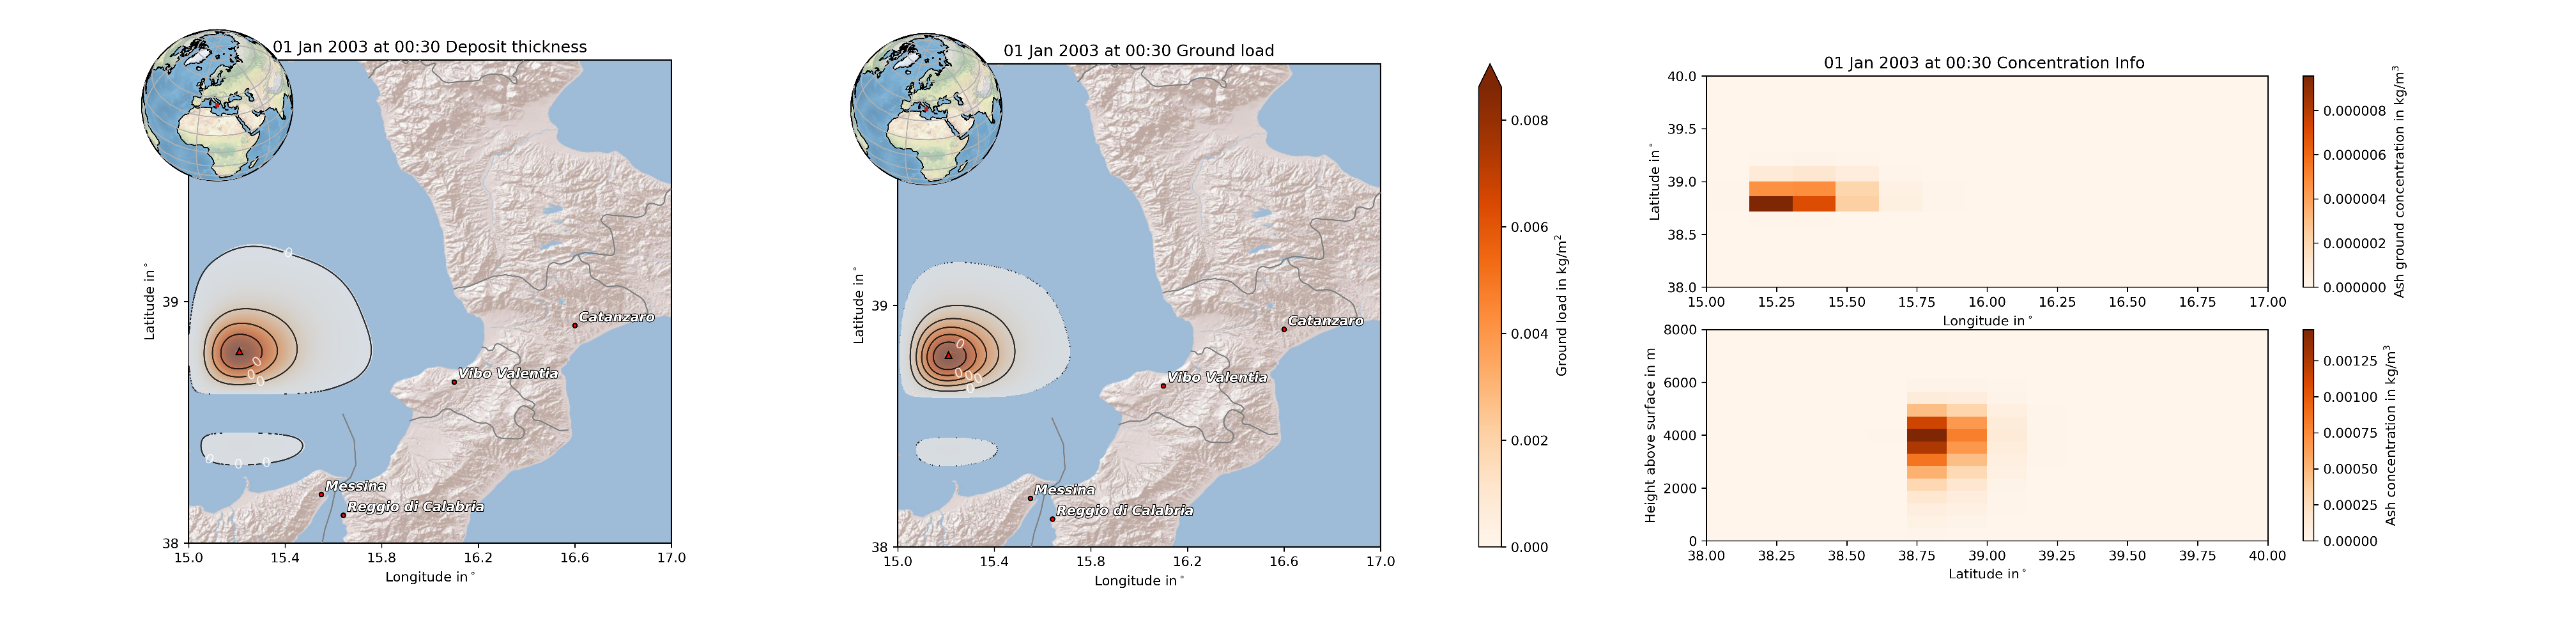

In [1]:
from IPython.display import Image
Image(filename='f3dpy_plots.png')

In [1]:
import os
import json

# set user-specific plotting parameters 
paras = {}
paras['plot_all'] = True # either set to True to plot all time steps (default) or give series of steps to plot e.g. [0, 1, 3, 10]
paras['figsize'] = (24.0/2.54,16.0/2.54)
paras['figedgecol'] = 'k' # color of figure edges
paras['figfacecol'] = 'w' # color of figure face
paras['format'] = 'png'
paras['dpi'] = 300 # resolution of output file
paras['alpha'] = 0.6 # transparency of plotted distributions
paras['plot_contour'] = True # plot contours of grids on map
paras['linew_contour'] = 1 # linewidth of contour lines
paras['linec_contour'] = 'k' # linecolor of contours
paras['labc_contour'] = 'w' # color of contour labels
paras['fonts_contour'] =10 # fontsize of contour labels
paras['ventcol'] = 'r' # facecolor of vent marker
paras['ventedgecol'] = 'k' # edgecolor of vent marker
paras['ventsize'] = 5 # markersize of vent
paras['cmap'] = 'Oranges' # used colormap for plotting distributions,'Oranges' is default
paras['background'] = 'gray' # real or gray shaded background topography
paras['autores'] = True # use automatically best background resolution for area
paras['manures'] = None # define own background resolution (should be less than 10)
paras['cities'] = {}# plot larger cities in given area
paras['cities']['plot'] = True # if False, no cities are plotted
paras['cities']['fcolor'] = 'red' # facecolor of circles at city locations
paras['cities']['ecolor'] = 'k' # edgecolor of circles at city locations
paras['cities']['size'] = 10 # size of scatter circles
paras['cities']['tstyle'] = 'italic' # text style of annotations
paras['cities']['tfcol'] = 'w' # annotation facecolor
paras['cities']['tecol'] = 'k' # annotation edgecolor
paras['cities']['tewidth'] = 1 # annotation edge linewidth
paras['cities']['tfweight'] = 'bold' # annotation font weight

paras['inset'] = {} # plot an inset showing the location of the area in a global view
paras['inset']['plot'] = True # if False, no inset is plotted
paras['inset']['locsiz'] = [0.09, 0.7, 0.3, 0.25] # location and size of inset, [0.09, 0.7, 0.3, 0.25] corresponds roughly to upper left corner
paras['inset']['content'] = 'real' # use shaded ocean and continent background, parameters below are ignored, 'normal' uses the parameters below
paras['inset']['col_contf'] = 'lightgray' # color of continent fill
paras['inset']['col_conte'] = 'black'  # color of continent edges
paras['inset']['linw_conte'] = .75  # linewidth of continent edges
paras['inset']['col_ocean'] = 'powderblue' # color of oceans
paras['inset']['col_rect'] = 'firebrick' # color of rectangle showing the area 

input_dic = {"producer": [ {"plotting_parameters": paras}]}

with open('input_parameters.json', 'w') as fp:
    json.dump(input_dic, fp)

In [ ]:
!dispel4py multi f3_dispel4py_plotting -n 10 -f input_parameters.json

Processes: {'producer0': range(0, 1), 'PlottingPE1': range(1, 10)}
sending the gload grid for time step (01 Jan 2003 at 00:01) to be plotted
sending the gload grid for time step (01 Jan 2003 at 00:30) to be plotted
sending the gload grid for time step (01 Jan 2003 at 01:00) to be plotted
sending the gload grid for time step (01 Jan 2003 at 01:30) to be plotted
sending the gload grid for time step (01 Jan 2003 at 02:00) to be plotted
sending the depoth grid for time step (01 Jan 2003 at 00:01) to be plotted
sending the depoth grid for time step (01 Jan 2003 at 00:30) to be plotted
sending the depoth grid for time step (01 Jan 2003 at 01:00) to be plotted
sending the depoth grid for time step (01 Jan 2003 at 01:30) to be plotted
sending the depoth grid for time step (01 Jan 2003 at 02:00) to be plotted
sending the airb grid for time step (01 Jan 2003 at 00:01) to be plotted
sending the airb grid for time step (01 Jan 2003 at 00:30) to be plotted
sending the airb grid for time step (01 Ja